In [1]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import pacf
from sklearn.preprocessing import MinMaxScaler
import os

In [2]:
# Dataset
df=pd.read_csv('./../../dataset/raw_jawa_tengah.csv', parse_dates=["date"], index_col="date")
#df['daily_case'] = df['daily_case'].str.replace(',','').astype(int)

# Cut dataset to start from 1 April 2022
df = df[24:]
df.head()

,daily_case
date,
2020-04-01,19
2020-04-02,5
2020-04-03,19
2020-04-04,15
2020-04-05,3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 766 entries, 2020-04-01 to 2022-05-06
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   daily_case  766 non-null    int64
dtypes: int64(1)
memory usage: 12.0 KB


In [4]:
df.shape

(766, 1)

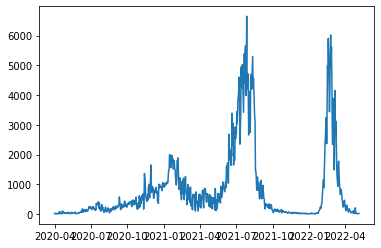

In [5]:
plt.plot(df)

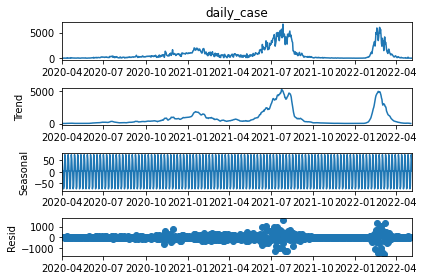

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df['daily_case'])
results.plot();

In [7]:
df.shape

(766, 1)

In [8]:
# stationarity check
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [9]:
adf_test(df['daily_case'])

1. ADF :  -3.2970712374287023
2. P-Value :  0.015009898921143103
3. Num Of Lags :  14
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 751
5. Critical Values :
	 1% :  -3.4390874066174355
	 5% :  -2.8653962034740705
	 10% :  -2.568823449196012


In [10]:
# Split data to train and test
train_size = int(len(df) * 0.75)
test_size=len(df)-train_size

train_data=df[:train_size]
test_data=df[train_size:]

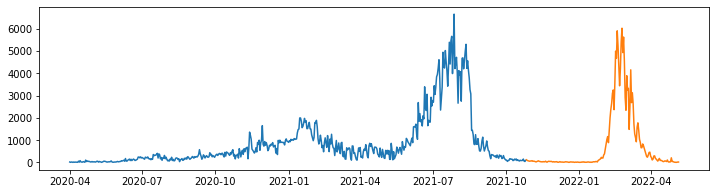

In [11]:
train_data=df[:train_size]
test_data=df[train_size:]
plt.figure(figsize=(12, 3))
plt.plot(train_data)
plt.plot(test_data)

In [12]:
from statsmodels.tsa.stattools import adfuller
#Ho: non stationary (ADF value <= 0.05)
#H1: stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [13]:
adfuller_test(df['daily_case'])

ADF Test Statistic : -3.2970712374287023
p-value : 0.015009898921143103
#Lags Used : 14
Number of Observations Used : 751
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [14]:
from pmdarima.arima import auto_arima
model = auto_arima(train_data, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=30,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,    # Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      )

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[30] intercept   : AIC=8264.039, Time=1.34 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=8343.967, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=8297.321, Time=0.30 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=8265.598, Time=1.53 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=8341.968, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[30] intercept   : AIC=8263.638, Time=0.13 sec
 ARIMA(1,1,1)(1,0,0)[30] intercept   : AIC=8264.122, Time=0.52 sec
 ARIMA(1,1,1)(1,0,1)[30] intercept   : AIC=inf, Time=3.88 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=8264.929, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[30] intercept   : AIC=8295.932, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[30] intercept   : AIC=8252.293, Time=0.08 sec
 ARIMA(2,1,1)(1,0,0)[30] intercept   : AIC=8252.187, Time=1.69 sec
 ARIMA(2,1,1)(2,0,0)[30] intercept   : AIC=8254.043, Time=4.24 sec
 ARIMA(2,1,1)(1,0,1)[30] intercept   : AIC=8254.053, Time=2.53 sec
 ARIMA(2,1,1)(0,0,1)[30]

In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  574
Model:             SARIMAX(2, 1, 0)x(0, 0, [1], 30)   Log Likelihood               -4120.105
Date:                              Sun, 29 May 2022   AIC                           8248.210
Time:                                      13:17:42   BIC                           8265.613
Sample:                                           0   HQIC                          8254.999
                                              - 574                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3640      0.020    -17.867      0.000      -0.404      -0.324
ar.L2         -0.2873      0.022    -12.999      0.000      -0.331      -0.244
ma.S.L30      -0.0610      0.027     -2.298      0.022      -0.113      -0.009
sigma2      1.037e+05   2482.079     41.798      0.000    9.89e+04    1.09e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2656.85
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):              66.76   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
model

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(0, 0, 1, 30),
      suppress_warnings=True, with_intercept=False)

In [17]:
# Split data to train and test
df = df.values
df = df.astype('float32')
train_size = int(len(df) * 0.75)
test_size=len(df)-train_size

train_data=df[0:train_size]
test_data=df[train_size:len(df)]

history = [x for x in train_data]
predictions = []

In [18]:
train_size

574

In [19]:
predictions

[]

In [20]:
from statsmodels.tsa.arima.model import ARIMA
# walk-forward validation
for t in range(len(test_data)):
	model = ARIMA(history, order=(2,1,0), seasonal_order=(0,0,1,30))
	model_fit = model.fit()
	output = model_fit.forecast(steps=1)
	yhat = output[0]
	predictions.append(yhat)
	obs = test_data[t]
	history.append(obs) #append real observation to history
	print('predicted=%f, expected=%f' % (yhat, obs))
    
    

predicted=80.809239, expected=118.000000
predicted=90.358342, expected=88.000000
predicted=95.692036, expected=73.000000
predicted=90.604899, expected=65.000000
predicted=76.591501, expected=54.000000
predicted=60.813341, expected=65.000000
predicted=69.394582, expected=65.000000
predicted=61.789436, expected=80.000000
predicted=74.982740, expected=52.000000
predicted=51.754204, expected=57.000000
predicted=60.727315, expected=51.000000
predicted=52.019730, expected=37.000000
predicted=44.966739, expected=23.000000
predicted=36.673359, expected=39.000000
predicted=38.578480, expected=58.000000
predicted=44.982987, expected=73.000000
predicted=62.431473, expected=47.000000
predicted=49.609960, expected=42.000000
predicted=55.202548, expected=30.000000
predicted=35.300075, expected=27.000000
predicted=34.074033, expected=26.000000
predicted=29.194714, expected=38.000000
predicted=33.147407, expected=25.000000
predicted=26.667735, expected=34.000000
predicted=34.250260, expected=55.000000

In [21]:
import math
from sklearn.metrics import mean_squared_error
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test_data, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 417.339


In [22]:
train_data

array([[1.900e+01],
       [5.000e+00],
       [1.900e+01],
       [1.500e+01],
       [3.000e+00],
       [1.900e+01],
       [8.000e+00],
       [1.500e+01],
       [1.100e+01],
       [2.000e+00],
       [7.000e+00],
       [5.700e+01],
       [1.300e+01],
       [8.100e+01],
       [2.500e+01],
       [1.500e+01],
       [1.400e+01],
       [3.800e+01],
       [2.400e+01],
       [7.000e+00],
       [1.040e+02],
       [4.000e+01],
       [6.800e+01],
       [4.100e+01],
       [5.200e+01],
       [3.800e+01],
       [2.200e+01],
       [2.200e+01],
       [4.100e+01],
       [1.900e+01],
       [2.800e+01],
       [2.800e+01],
       [1.600e+01],
       [2.700e+01],
       [5.100e+01],
       [5.400e+01],
       [1.500e+01],
       [4.500e+01],
       [3.100e+01],
       [2.300e+01],
       [3.000e+00],
       [1.800e+01],
       [3.600e+01],
       [5.900e+01],
       [4.800e+01],
       [4.300e+01],
       [2.500e+01],
       [1.500e+01],
       [2.500e+01],
       [2.500e+01],


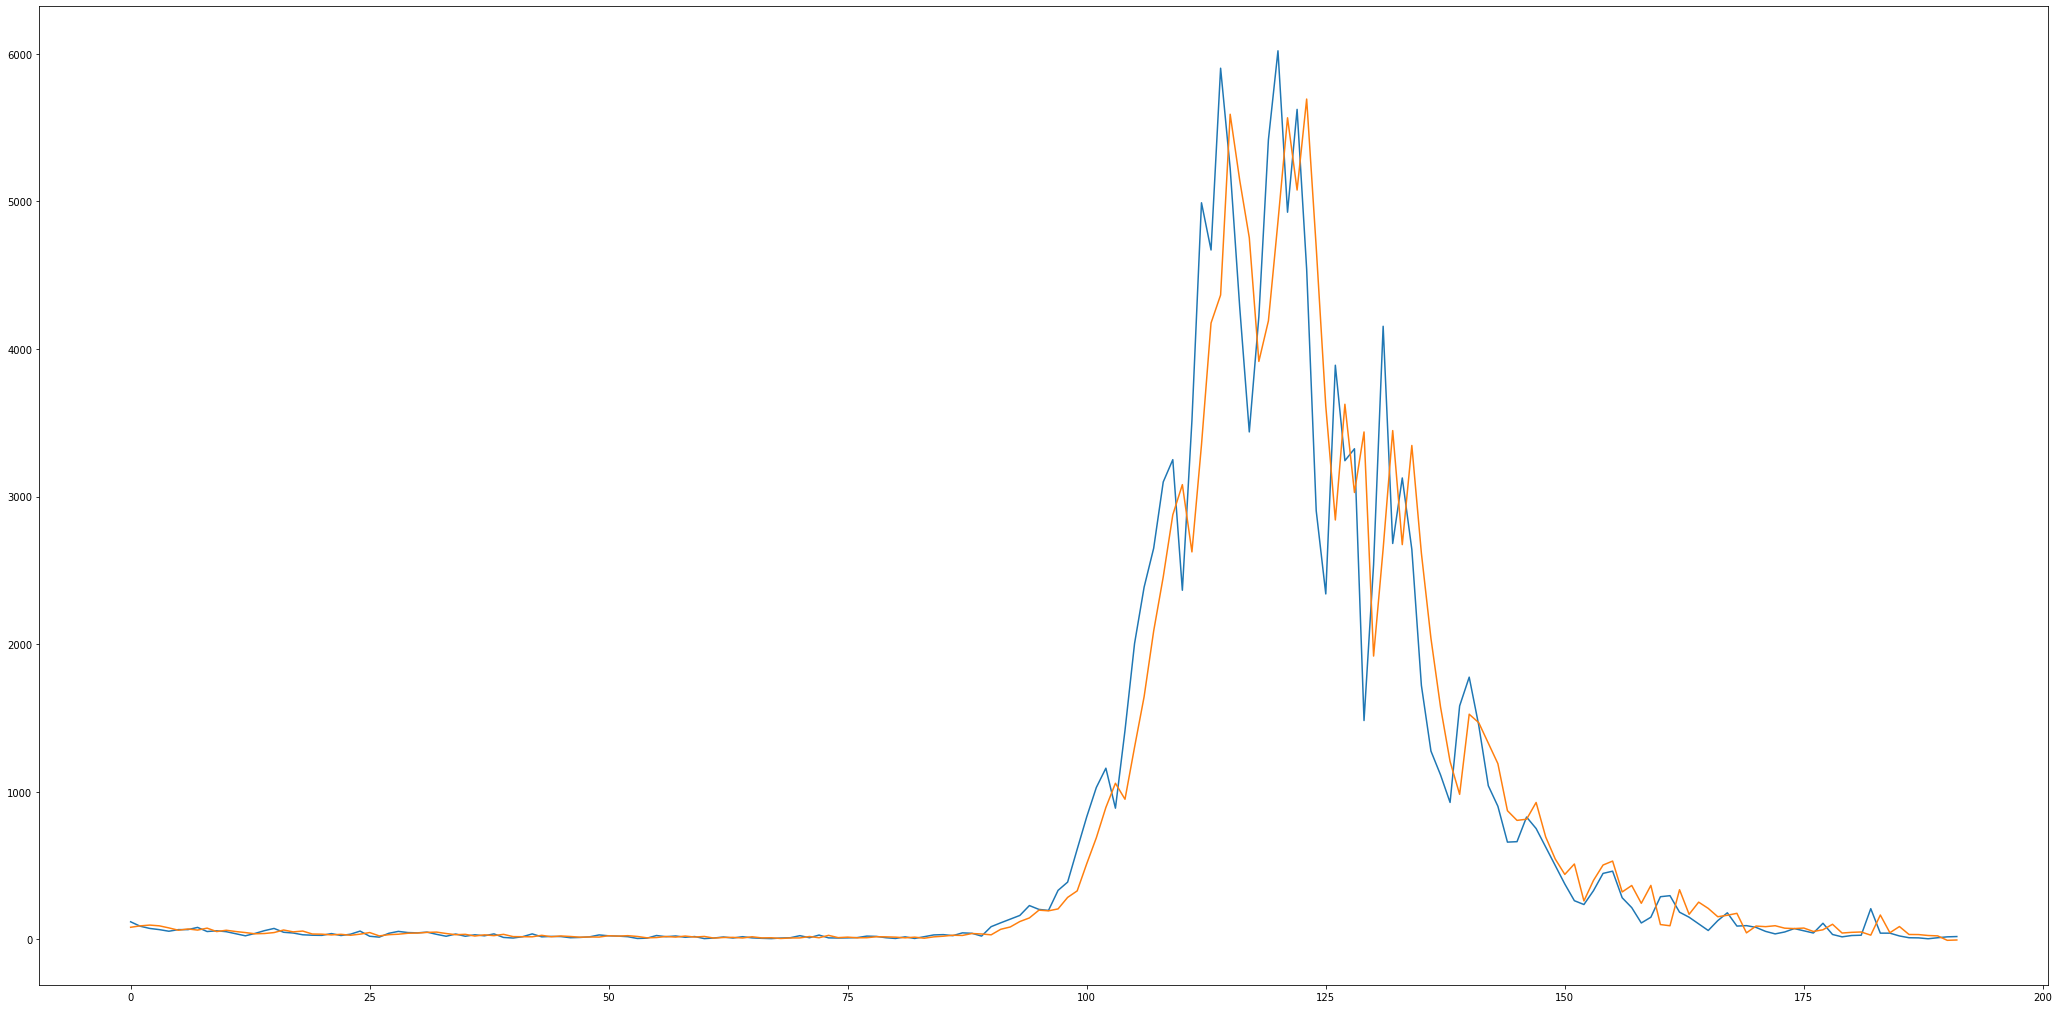

In [23]:
plt.figure(figsize=(36,18)) 
plt.plot(test_data)
plt.plot(predictions)

plt.show()

In [24]:
history

[array([19.], dtype=float32),
 array([5.], dtype=float32),
 array([19.], dtype=float32),
 array([15.], dtype=float32),
 array([3.], dtype=float32),
 array([19.], dtype=float32),
 array([8.], dtype=float32),
 array([15.], dtype=float32),
 array([11.], dtype=float32),
 array([2.], dtype=float32),
 array([7.], dtype=float32),
 array([57.], dtype=float32),
 array([13.], dtype=float32),
 array([81.], dtype=float32),
 array([25.], dtype=float32),
 array([15.], dtype=float32),
 array([14.], dtype=float32),
 array([38.], dtype=float32),
 array([24.], dtype=float32),
 array([7.], dtype=float32),
 array([104.], dtype=float32),
 array([40.], dtype=float32),
 array([68.], dtype=float32),
 array([41.], dtype=float32),
 array([52.], dtype=float32),
 array([38.], dtype=float32),
 array([22.], dtype=float32),
 array([22.], dtype=float32),
 array([41.], dtype=float32),
 array([19.], dtype=float32),
 array([28.], dtype=float32),
 array([28.], dtype=float32),
 array([16.], dtype=float32),
 array([27.], d

In [25]:
model = ARIMA(history, order=(2,1,0), seasonal_order=(0,0,1,30))

model_fit = model.fit()
output = model_fit.forecast(steps=1)
# multi-step out-of-sample forecast
start_index = len(history)
end_index = start_index + 29
forecast = model_fit.predict(start=start_index, end=end_index)

history = [x for x in df]
day = 1
for yhat in forecast:
	print('Day %d: %f' % (day, yhat))
	history.append(yhat)
	day += 1

# forecast = model_fit.forecast(steps=30)

Day 1: 30.029861
Day 2: 28.393785
Day 3: 39.517774
Day 4: 50.880970
Day 5: 47.598922
Day 6: 44.103825
Day 7: 53.915243
Day 8: 47.640135
Day 9: 47.786639
Day 10: 52.279354
Day 11: 56.259824
Day 12: 56.528378
Day 13: 55.491469
Day 14: 57.438521
Day 15: 58.156313
Day 16: 53.340607
Day 17: 60.942261
Day 18: 62.547582
Day 19: 62.317983
Day 20: 64.035946
Day 21: 46.761235
Day 22: 62.435510
Day 23: 62.756446
Day 24: 64.881024
Day 25: 66.312748
Day 26: 67.526101
Day 27: 68.937783
Day 28: 69.448322
Day 29: 66.759802
Day 30: 65.152341


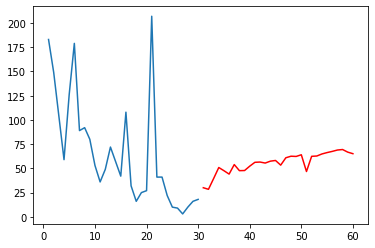

In [26]:
day_new=np.arange(1,31) # dari data 30 hari terakhir
day_pred=np.arange(31,61) #predict 30 hari kedepan

plt.plot(day_new, df[736:766])
plt.plot(day_pred, forecast, color='red')
plt.show()

C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


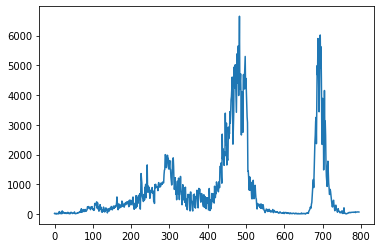

In [27]:
plt.plot(history)
plt.show()